In [53]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [54]:
plt.style.use('seaborn')

In [55]:
start_date = datetime(2010, 1, 1)
end_date = datetime(2021, 6, 30)

In [56]:
tickers = ['NPN.JO','BTI.JO','BHP.JO','CFR.JO','AGL.JO',
           'FSR.JO','SBK.JO','VOD.JO','MTN.JO','ABG.JO',
           'ANG.JO','IMP.JO','WHL.JO','EXX.JO','GRT.JO',
           'RDF.JO','DSY.JO','GFI.JO','SHP.JO','INL.JO' ]

In [57]:
df = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  20 of 20 completed


In [58]:
stocks = df['Close']/100

# Exploratory data analysis:

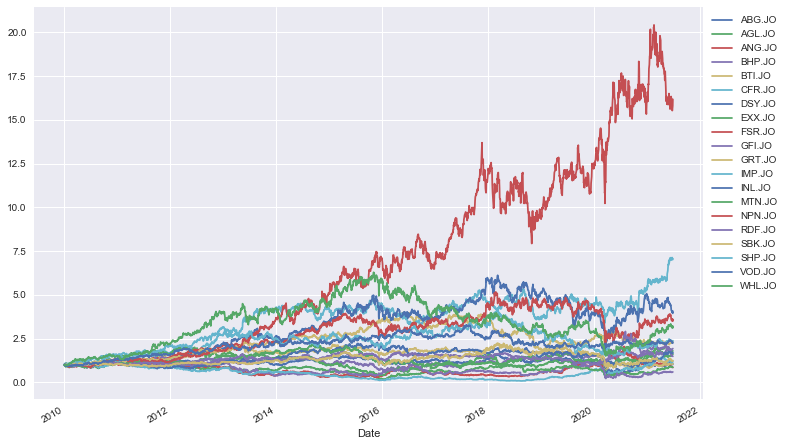

In [59]:
stock_normed = stocks/stocks.iloc[0]
stock_normed.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1,1), labels=stocks.columns);

Naspers is the runaway stock.

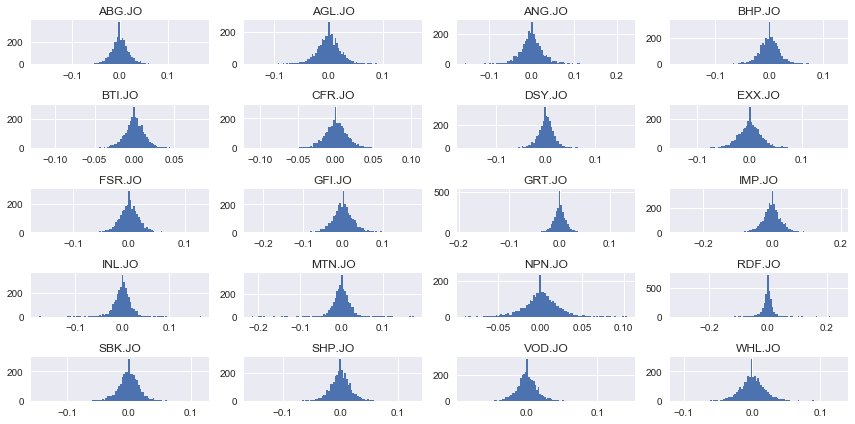

In [60]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.hist(bins=100,figsize=(12,6))
plt.tight_layout();

Naspers shows a platykurtic distribution of returns, at first glance.

In [61]:
stocks.pct_change().corr().applymap('{:.2f}'.format)

,ABG.JO,AGL.JO,ANG.JO,BHP.JO,BTI.JO,CFR.JO,DSY.JO,EXX.JO,FSR.JO,GFI.JO,GRT.JO,IMP.JO,INL.JO,MTN.JO,NPN.JO,RDF.JO,SBK.JO,SHP.JO,VOD.JO,WHL.JO
ABG.JO,1.00,0.27,-0.04,0.22,0.03,0.17,0.55,0.24,0.71,-0.01,0.43,0.22,0.51,0.41,0.23,0.40,0.75,0.40,0.34,0.49
AGL.JO,0.27,1.00,0.19,0.79,0.13,0.37,0.26,0.54,0.33,0.18,0.21,0.49,0.43,0.30,0.30,0.21,0.32,0.20,0.20,0.24
ANG.JO,-0.04,0.19,1.00,0.19,0.06,0.05,0.02,0.14,-0.02,0.79,0.00,0.37,-0.00,0.02,0.04,0.03,-0.03,0.00,0.04,0.02
BHP.JO,0.22,0.79,0.19,1.00,0.20,0.43,0.22,0.49,0.28,0.17,0.17,0.44,0.40,0.28,0.32,0.14,0.29,0.21,0.20,0.24
BTI.JO,0.03,0.13,0.06,0.20,1.00,0.30,0.11,0.06,0.02,0.06,0.05,0.06,0.18,0.12,0.13,0.05,0.02,0.05,0.08,0.08
CFR.JO,0.17,0.37,0.05,0.43,0.30,1.00,0.20,0.26,0.18,0.07,0.18,0.24,0.38,0.20,0.29,0.09,0.20,0.14,0.19,0.20
DSY.JO,0.55,0.26,0.02,0.22,0.11,0.20,1.00,0.24,0.58,0.02,0.46,0.22,0.48,0.39,0.28,0.45,0.58,0.38,0.35,0.48
EXX.JO,0.24,0.54,0.14,0.49,0.06,0.26,0.24,1.00,0.30,0.15,0.20,0.42,0.32,0.28,0.25,0.18,0.31,0.20,0.17,0.21
FSR.JO,0.71,0.33,-0.02,0.28,0.02,0.18,0.58,0.30,1.00,-0.00,0.48,0.26,0.54,0.43,0.31,0.41,0.77,0.45,0.38,0.53
GFI.JO,-0.01,0.18,0.79,0.17,0.06,0.07,0.02,0.15,-0.00,1.00,0.02,0.38,0.03,0.01,0.04,0.04,-0.02,0.00,0.02,0.02


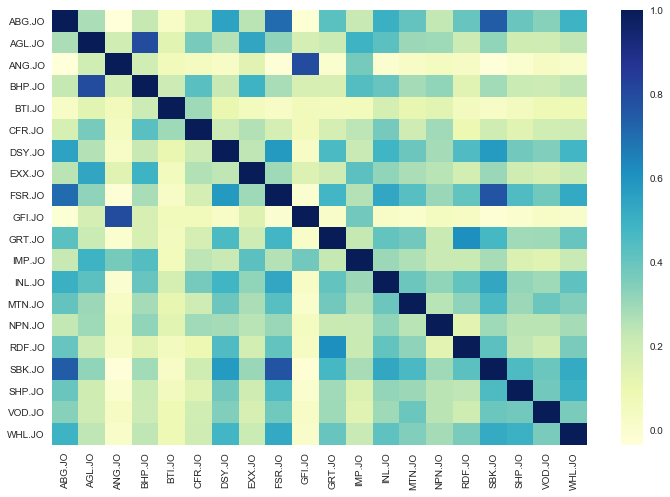

In [62]:
sns.heatmap(stocks.pct_change(1).corr(), cmap='YlGnBu')
fig = plt.gcf()
fig.set_size_inches(12,8);

The banks are highly correlated, as we would expect. <br>
Some of the mining stocks (Anglo & BHP, Anglo & Goldfields) are also highly correlated.

# PyPortfolioOpt

In [63]:
class PortOptBacktester(object):
    """
        Class for backtesting of portfolio optimisation strategies.
        
        Attributes:
        ===========
        tickers: list
            list of stock tickers that constitute the portfolio.
        start_date: datetime
            start date for historical data from Yahoo finance API.
        end_date: datetime
            end date for historical data from Yahoo finance API.
        method: str
            the portfolio construction technique being backtested.
        lookback: int
            the lookback period used at each rebalancing date.
            
        Methods:
        ===========
        prepare_data():
            retrieves historical stock prices and derives rebalancing dates.
        run_strategy():
            runs the given portfolio construction method at each rebalancing date.
        compute_performance():
            computes the performance of the portfolio compared to the equal-weighted portfolio.
        compute_descriptive_stats():
            computes the rolling annual return statistics.
        plot_results():
            plots the results of the backtest.
            
    """
    
    
    def __init__(self, tickers, start_date, end_date, lookback):
        self.tickers: list = tickers
        self.start_date: datetime = start_date
        self.end_date: datetime = end_date
        self.lookback: int = lookback
        self.rf: float = 0.04
        self.weights: pd.DataFrame
        self.prepare_data()
        
    
    def find_first_monday(self, dt) -> datetime:
        """Finds the first Monday of each month, i.e. the rebalancing dates.
        """
        d = datetime(dt.year, int(dt.month), 7)
        offset = -d.weekday()
        return d + timedelta(offset)
        
        
    def prepare_data(self) -> None:
        """Prepares the data required for optimisation.
        """
        raw = yf.download(tickers, start=start_date, end=end_date)
        raw = raw[raw.index.weekday<=4]
        self.data = raw['Close']/100
        rebal_dates = [self.find_first_monday(dt) for dt in self.data.index[self.lookback:]]
        self.rebal_dates = set(rebal_dates)
        
        
    def run_strategy(self, method) -> pd.DataFrame:
        """Runs the strategy and returns the results.
        """
        self.weights = pd.DataFrame(index=self.data.index, columns=self.data.columns)
        if method == "maxsharpe":
            for dt in self.rebal_dates:
                df = self.data[dt-timedelta(days=self.lookback):dt]
                mu = mean_historical_return(df)
                S = CovarianceShrinkage(df).ledoit_wolf()
                ef = EfficientFrontier(mu, S, weight_bounds=(0,0.2))
                w = ef.max_sharpe()
                self.weights.loc[dt] = w
        elif method == "minvol":
            for dt in self.rebal_dates:
                df = self.data[dt-timedelta(days=self.lookback):dt]
                mu = mean_historical_return(df)
                S = CovarianceShrinkage(df).ledoit_wolf()
                ef = EfficientFrontier(mu, S, weight_bounds=(0,0.2))
                w = ef.min_volatility()
                self.weights.loc[dt] = w
        else:
            raise ValueError("Method must either be 'minvol' or 'maxsharpe'")
        self.compute_performance()
        return self.results
        
        
    def compute_performance(self) -> None:
        """ Compute the performance of the strategy compared 
            to the equal-weighted portfolio.
        """ 
        self.weights = self.weights.ffill().dropna()
        # Some rebal dates may not be in historical data due to public holidays
        common_index = self.data.index.intersection(self.weights.index) 
        self.weights = self.weights[self.weights.index.isin(common_index)]
        self.data_ = self.data[self.data.index.isin(common_index)]
        # Portfolio performance
        port_rets = (self.data_.pct_change() * self.weights).sum(axis=1)
        self.strat = np.cumprod(port_rets.add(1))
        self.equal = np.multiply(self.data_, 1/len(self.tickers)).sum(axis=1)
        self.results = self.compute_descriptive_stats()
        
        
    def compute_descriptive_stats(self) -> pd.DataFrame:
        """Compute rolling annual return statistics.
        """
        stats = pd.DataFrame(columns=['Equal-Weighted', 'Strategy'])
        stats['Equal-Weighted'] = self.equal.pct_change(260).describe()
        stats['Strategy'] = self.strat.pct_change(260).describe()
        # Total return
        stats.loc['Total', 'Strategy'] = self.strat[-1]-1
        stats.loc['Total', 'Equal-Weighted'] = (self.equal[-1]/self.equal[0])-1
        # Sharpe ratio
        stats.loc['Sharpe', 'Strategy'] = (stats.iloc[1,1]-self.rf)/stats.iloc[2,1]
        stats.loc['Sharpe', 'Equal-Weighted'] = (stats.iloc[1,0]-self.rf)/stats.iloc[2,0]
        # Formatting
        stats.iloc[1:-1,:] = stats.iloc[1:-1,:].applymap('{:.2%}'.format)
        stats.iloc[-1,:] = stats.iloc[-1,:].apply('{:.2f}'.format)
        return stats
        
        
    def plot_results(self):
        ''' Plots the cumulative performance of the strategy compared 
            to the equal-weighted portfolio.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.') 
        title = 'Cumulative performance of Strategy vs Equal-Weighted Portfolio'
        self.strat.plot(title=title, figsize=(10,6), label='Strategy')
        (self.equal/self.equal[0]).plot(label='Equal-Weighted')
        plt.legend();
        

In [64]:
demo = PortOptBacktester(tickers, start_date, end_date, 180)

[*********************100%***********************]  20 of 20 completed


In [65]:
demo.run_strategy('maxsharpe')

,Equal-Weighted,Strategy
count,2519.0,2519.0
mean,10.58%,14.07%
std,10.25%,11.92%
min,-25.01%,-18.97%
25%,5.21%,6.56%
50%,9.44%,14.73%
75%,15.70%,22.51%
max,74.61%,54.35%
Total,182.22%,272.04%
Sharpe,0.64,0.84


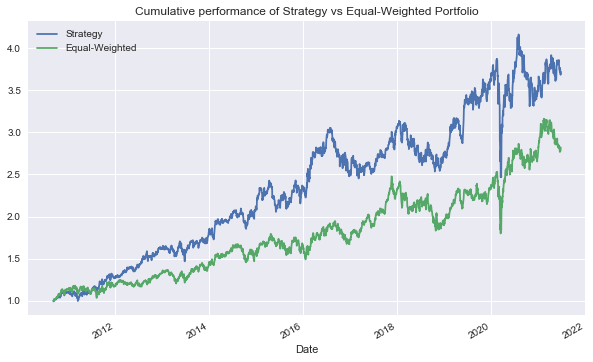

In [66]:
demo.plot_results()

In [67]:
demo.run_strategy('minvol')

,Equal-Weighted,Strategy
count,2519.0,2519.0
mean,10.58%,7.61%
std,10.25%,10.92%
min,-25.01%,-29.50%
25%,5.21%,0.73%
50%,9.44%,8.20%
75%,15.70%,14.77%
max,74.61%,38.28%
Total,182.22%,115.53%
Sharpe,0.64,0.33


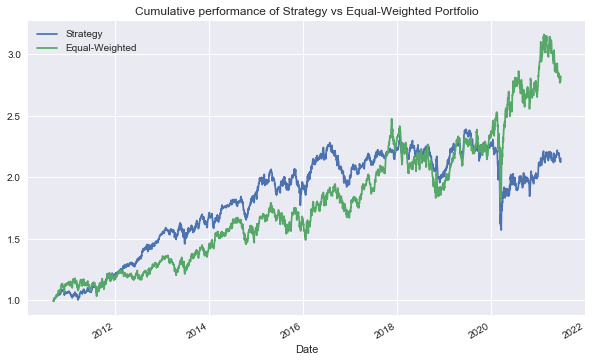

In [68]:
demo.plot_results()